<a href="https://colab.research.google.com/github/manjunathsirur1994/Time_series_forecasting/blob/main/TS_SARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import yfinance as yf

In [62]:
ticker = 'LLOYDSME.NS'

df = yf.download(ticker, start='2000-01-01', multi_level_index=False)
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-07-17 00:00:00+00:00,562.558289,563.299988,582.700012,550.500000,554.000000,417232
2023-07-18 00:00:00+00:00,543.583313,544.299988,573.900024,531.000000,573.900024,284708
2023-07-19 00:00:00+00:00,565.504395,566.250000,572.000000,541.250000,564.700012,208966
2023-07-20 00:00:00+00:00,563.307312,564.049988,572.700012,557.000000,572.700012,108284
2023-07-21 00:00:00+00:00,557.964355,558.700012,564.500000,550.049988,564.500000,189224


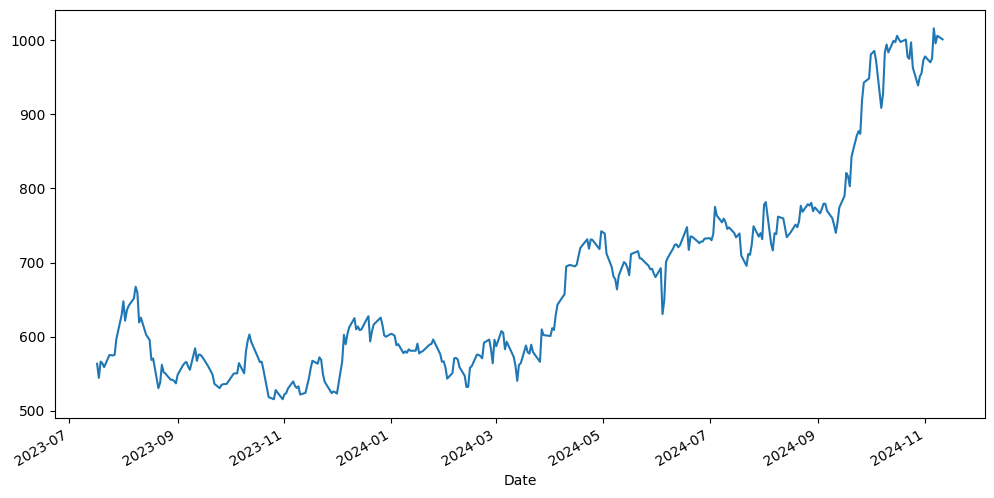

In [63]:
df['Close'].plot(figsize=(12,6));

In [64]:
df.shape

(326, 6)

In [65]:
df = df.resample("B").last()
df.shape

(346, 6)

In [66]:
df.fillna(method='ffill', inplace=True)
df.shape

<ipython-input-66-1df6602c9f4d>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


(346, 6)

In [67]:
df.isna().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [68]:
ts = df[['Close']]
ts.head()

,Close
Date,
2023-07-17 00:00:00+00:00,563.299988
2023-07-18 00:00:00+00:00,544.299988
2023-07-19 00:00:00+00:00,566.250000
2023-07-20 00:00:00+00:00,564.049988
2023-07-21 00:00:00+00:00,558.700012


In [69]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:{result[4]}')

ADF Statistic: 0.19461754255502062
p-value: 0.971958087376209
Critical Values:{'1%': -3.4494474563375737, '5%': -2.8699542285903887, '10%': -2.5712527305187987}


In [70]:
ts['close_diff'] = ts['Close'].diff()
ts.dropna(inplace=True)
ts.shape

<ipython-input-70-d9944f5a6e05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['close_diff'] = ts['Close'].diff()
<ipython-input-70-d9944f5a6e05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.dropna(inplace=True)


(345, 2)

In [71]:
results = adfuller(ts['close_diff'])
print(f'ADF Statistic: {results[0]}')
print(f'p-value: {results[1]}')
print(f'Critical Values:{results[4]}')

ADF Statistic: -14.487849715134685
p-value: 6.2183728855575555e-27
Critical Values:{'1%': -3.449559661646851, '5%': -2.8700035112469626, '10%': -2.5712790073013796}


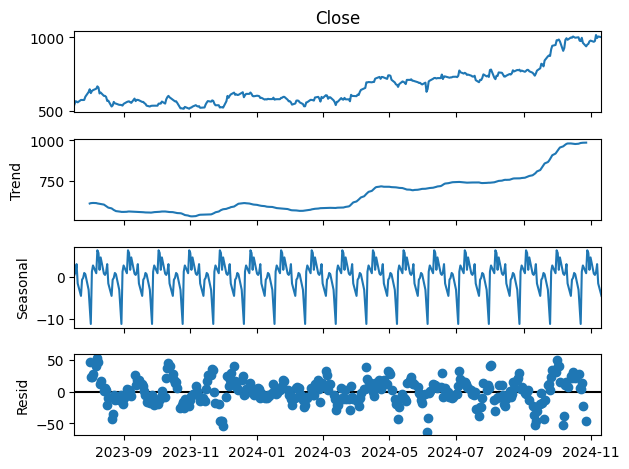

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts['Close'], model='additive', period=20)
result.plot();

<ipython-input-73-318f7c0b0101>:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/np.abs(fft_freq), np.abs(fft_vals))


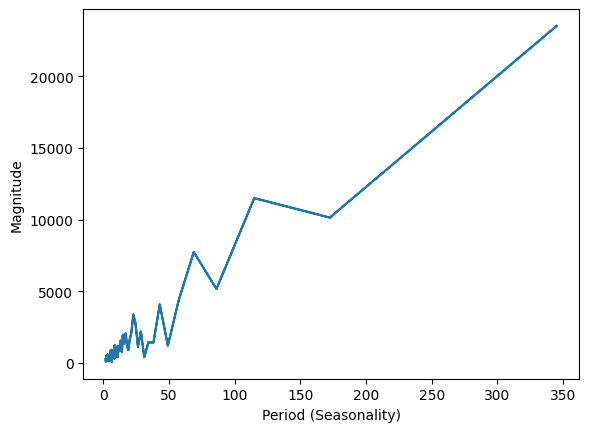

In [73]:
import numpy as np
import matplotlib.pyplot as plt

fft_vals = np.fft.fft(ts['Close'])
fft_freq = np.fft.fftfreq(len(fft_vals))

# Plot the magnitudes of the FFT to find the dominant frequency
plt.plot(1/np.abs(fft_freq), np.abs(fft_vals))
plt.xlabel('Period (Seasonality)')
plt.ylabel('Magnitude')
plt.show()

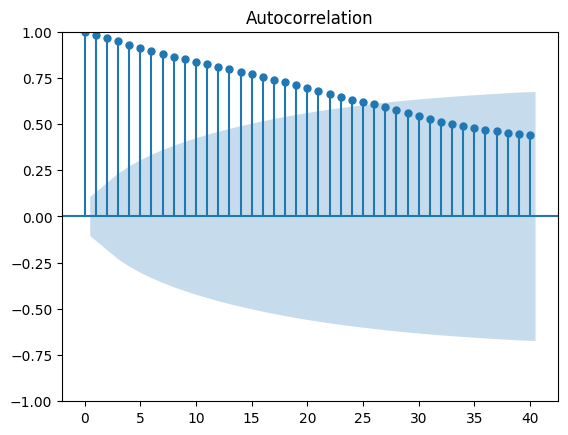

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(ts['Close'], lags=40)  # Adjust lags to view multiple cycles
plt.show()

In [75]:
ts.shape

(345, 2)

In [76]:
df_train = ts.head(300)
df_test = ts.tail(45)

In [77]:
from statsmodels.tsa.statespace import sarimax
import itertools

model_params = {}
P=D=Q = range(0,2)
S = [20]
PDQ = list(itertools.product(P,D,Q,S))

for params in PDQ:
  try:
    model = sarimax.SARIMAX(df_train['Close'], order=(0,1,3), seasonal_order=(params))
    model_fit = model.fit()
    model_params[params] = model_fit.aic
  except:
    print("error")

In [78]:
min(model_params, key=model_params.get)

(0, 1, 1, 20)

In [79]:
model = sarimax.SARIMAX(df_train['Close'], order=(0,1,3), seasonal_order=(0,1,1,20)) # to find pdq value build arima model first then take optimal pdq value.
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  300
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 20)   Log Likelihood               -1168.849
Date:                              Mon, 11 Nov 2024   AIC                           2347.698
Time:                                      08:32:31   BIC                           2365.854
Sample:                                  07-18-2023   HQIC                          2354.981
                                       - 09-09-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0406      0.060     -0.674      0.500      -0.158       0.077
ma.L2         -0.0576      0.045     -1.275      0.202      -0.146       0.031
ma.L3          0.0146      0.075      0.195      0.846      -0.132       0.161
ma.S.L20      -0.9805      0.289     -3.397      0.001      -1.546      -0.415
sigma2       214.0122     54.465      3.929      0.000     107.263     320.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.03
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
y_pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
y_pred.head()

,predicted_mean
2024-09-10 00:00:00+00:00,761.386634
2024-09-11 00:00:00+00:00,762.147785
2024-09-12 00:00:00+00:00,763.399217
2024-09-13 00:00:00+00:00,758.700263
2024-09-16 00:00:00+00:00,755.609587


In [81]:
df_test['Close'].head()

,Close
Date,
2024-09-10 00:00:00+00:00,750.750000
2024-09-11 00:00:00+00:00,740.000000
2024-09-12 00:00:00+00:00,754.299988
2024-09-13 00:00:00+00:00,774.099976
2024-09-16 00:00:00+00:00,790.000000


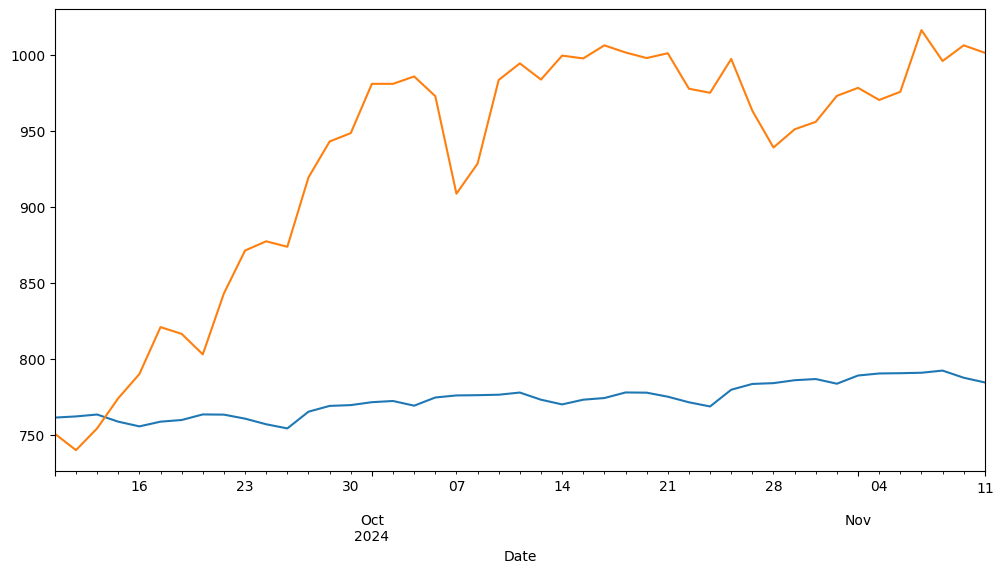

In [82]:
y_pred.plot(figsize=(12,6))
df_test['Close'].plot();

In [83]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['Close'], y_pred)

30372.677545155544

In [84]:
import math

math.sqrt(mean_squared_error(df_test['Close'], y_pred))

174.27758761572167

In [ ]:
# USING EXOGENOUS VARIABLES TO THE MODEL

In [130]:
ts

,Close,close_diff
Date,,
2023-07-18 00:00:00+00:00,544.299988,-19.000000
2023-07-19 00:00:00+00:00,566.250000,21.950012
2023-07-20 00:00:00+00:00,564.049988,-2.200012
2023-07-21 00:00:00+00:00,558.700012,-5.349976
2023-07-24 00:00:00+00:00,575.099976,16.399963
...,...,...
2024-11-05 00:00:00+00:00,975.500000,5.349976
2024-11-06 00:00:00+00:00,1016.049988,40.549988
2024-11-07 00:00:00+00:00,995.750000,-20.299988


In [131]:
df = ts.copy()
df.head()

,Close,close_diff
Date,,
2023-07-18 00:00:00+00:00,544.299988,-19.000000
2023-07-19 00:00:00+00:00,566.250000,21.950012
2023-07-20 00:00:00+00:00,564.049988,-2.200012
2023-07-21 00:00:00+00:00,558.700012,-5.349976
2023-07-24 00:00:00+00:00,575.099976,16.399963


In [132]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['day_name'] = df.index.day_name()
df['quarter'] = df.index.quarter
df['dayofyear'] = df.index.dayofyear
df['isweekend'] = df['dayofweek'] >= 5
df.head()

,Close,close_diff,year,month,day,dayofweek,day_name,quarter,dayofyear,isweekend
Date,,,,,,,,,,
2023-07-18 00:00:00+00:00,544.299988,-19.000000,2023,7,18,1,Tuesday,3,199,False
2023-07-19 00:00:00+00:00,566.250000,21.950012,2023,7,19,2,Wednesday,3,200,False
2023-07-20 00:00:00+00:00,564.049988,-2.200012,2023,7,20,3,Thursday,3,201,False
2023-07-21 00:00:00+00:00,558.700012,-5.349976,2023,7,21,4,Friday,3,202,False
2023-07-24 00:00:00+00:00,575.099976,16.399963,2023,7,24,0,Monday,3,205,False


In [133]:
import pandas as pd

dummies = pd.get_dummies(df['day_name'])
df.drop(columns=['day_name'], inplace=True)
df = pd.concat([df, dummies], axis=1)
df.head()

,Close,close_diff,year,month,day,dayofweek,quarter,dayofyear,isweekend,Friday,Monday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,,
2023-07-18 00:00:00+00:00,544.299988,-19.000000,2023,7,18,1,3,199,False,False,False,False,True,False
2023-07-19 00:00:00+00:00,566.250000,21.950012,2023,7,19,2,3,200,False,False,False,False,False,True
2023-07-20 00:00:00+00:00,564.049988,-2.200012,2023,7,20,3,3,201,False,False,False,True,False,False
2023-07-21 00:00:00+00:00,558.700012,-5.349976,2023,7,21,4,3,202,False,True,False,False,False,False
2023-07-24 00:00:00+00:00,575.099976,16.399963,2023,7,24,0,3,205,False,False,True,False,False,False


In [134]:
df.replace({True:1, False:0}, inplace=True)
df.head()

<ipython-input-134-e20c9d4fb221>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True:1, False:0}, inplace=True)


,Close,close_diff,year,month,day,dayofweek,quarter,dayofyear,isweekend,Friday,Monday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,,
2023-07-18 00:00:00+00:00,544.299988,-19.000000,2023,7,18,1,3,199,0,0,0,0,1,0
2023-07-19 00:00:00+00:00,566.250000,21.950012,2023,7,19,2,3,200,0,0,0,0,0,1
2023-07-20 00:00:00+00:00,564.049988,-2.200012,2023,7,20,3,3,201,0,0,0,1,0,0
2023-07-21 00:00:00+00:00,558.700012,-5.349976,2023,7,21,4,3,202,0,1,0,0,0,0
2023-07-24 00:00:00+00:00,575.099976,16.399963,2023,7,24,0,3,205,0,0,1,0,0,0


In [135]:
df.shape

(345, 14)

In [136]:
df_train = df.head(300)
df_test = df.tail(45)

In [137]:
model = sarimax.SARIMAX(df_train['Close'],
                        order=(0,1,3),
                        seasonal_order=(0,1,1,20),
                        exog=df_train.drop(columns=['Close']))                           # to find pdq value build arima model first then take optimal pdq value.
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  300
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 20)   Log Likelihood                -982.327
Date:                              Mon, 11 Nov 2024   AIC                           2000.654
Time:                                      09:05:22   BIC                           2066.016
Sample:                                  07-18-2023   HQIC                          2026.874
                                       - 09-09-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close_diff     0.4996      0.006     85.288      0.000       0.488       0.511
year          -0.0499     54.472     -0.001      0.999    -106.813     106.713
month         97.2392     40.740      2.387      0.017      17.390     177.088
day            3.1673      1.334      2.375      0.018       0.553       5.781
dayofweek      0.0007   1.22e+04   6.03e-08      1.000   -2.39e+04    2.39e+04
quarter       -1.5509      1.623     -0.955      0.339      -4.733       1.631
dayofyear     -3.1913      1.348     -2.367      0.018      -5.834      -0.549
isweekend           0      0.000          0      1.000      -0.001       0.001
Friday         0.0002    3.4e+04   6.68e-09      1.000   -6.67e+04    6.67e+04
Monday     -8.551e-06   3.76e+04  -2.28e-10      1.000   -7.37e+04    7.37e+04
Thursday       0.0001   5.75e+04   2.06e-09      1.000   -1.13e+05    1.13e+05
Tuesday       -0.0002   5.18e+04   -3.9e-09      1.000   -1.02e+05    1.02e+05
Wednesday     -0.0002    4.6e+04  -3.57e-09      1.000   -9.01e+04    9.01e+04
ma.L1          0.9306      0.080     11.563      0.000       0.773       1.088
ma.L2         -0.1046      0.088     -1.186      0.236      -0.277       0.068
ma.L3         -0.0448      0.057     -0.791      0.429      -0.156       0.066
ma.S.L20      -0.9772      0.289     -3.384      0.001      -1.543      -0.411
sigma2        55.0497     14.171      3.885      0.000      27.275      82.825
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.71
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.07
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.26e+25. Standard errors may be unstable.
"""

In [138]:
y_pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1], exog=df_test.drop(columns=['Close']))
y_pred.head()

,predicted_mean
2024-09-10 00:00:00+00:00,755.165241
2024-09-11 00:00:00+00:00,754.931409
2024-09-12 00:00:00+00:00,768.662614
2024-09-13 00:00:00+00:00,769.421693
2024-09-16 00:00:00+00:00,763.747447


In [139]:
df_test['Close'].head()

,Close
Date,
2024-09-10 00:00:00+00:00,750.750000
2024-09-11 00:00:00+00:00,740.000000
2024-09-12 00:00:00+00:00,754.299988
2024-09-13 00:00:00+00:00,774.099976
2024-09-16 00:00:00+00:00,790.000000


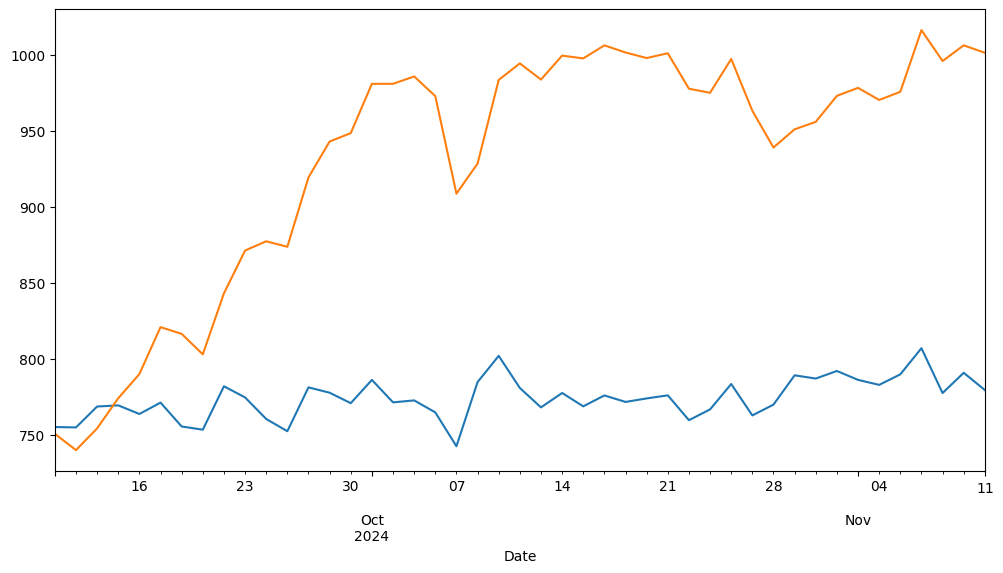

In [140]:
y_pred.plot(figsize=(12,6));
df_test['Close'].plot();

In [141]:
mean_squared_error(df_test['Close'], y_pred)

30344.870615391315

In [144]:
math.sqrt(mean_squared_error(df_test['Close'], y_pred))

174.19779164900834